#  Cheapest day before a flight to buy tickets prediction - Iteration 0

In [411]:
import sklearn
import pandas as pd
import seaborn
from types import SimpleNamespace

iterations = SimpleNamespace(
    zero=SimpleNamespace(),
    one=SimpleNamespace()
)

# 📦 Data provisioning
The flights is gathered from **google flights**, using a *webscraper*. It includes data from the routes **SOF-EIN** and **EIN-SOF**. The dataset includes data from **02.2025 - 12.2025**

In [412]:
data1 = pd.read_csv('./datasets/iteration0/flight_prices_SOF_EIN.csv', parse_dates=["departureDate"])
data2 = pd.read_csv('./datasets/iteration0/flight_prices_EIN_SOF.csv', parse_dates=["departureDate"])

iterations.zero.main_data = pd.concat([data1, data2])

# 📃 Sample the data


In [413]:
iterations.zero.main_data.sample(10)

,daysAgo,departureDate,price,departure_airport,arrival_airport,is_public_holiday,is_school_holiday
8768,169,2025-07-31,131,Sofia,Eindhoven,False,True
13118,286,2025-10-14,74,Sofia,Eindhoven,False,True
9805,186,2025-08-17,225,Sofia,Eindhoven,False,True
15257,328,2025-11-28,94,Sofia,Eindhoven,False,False
14348,300,2025-11-06,94,Sofia,Eindhoven,False,False
45,16,2025-02-28,99,Eindhoven,Sofia,False,True
1221,87,2025-03-27,59,Sofia,Eindhoven,False,False
13045,235,2025-10-12,84,Sofia,Eindhoven,False,True
3187,106,2025-04-29,64,Sofia,Eindhoven,False,True
6379,134,2025-06-16,56,Eindhoven,Sofia,False,False


In [414]:
group_info = iterations.zero.main_data.groupby(["departure_airport"])["departure_airport"].count()
group_info

departure_airport
Eindhoven    16958
Sofia        16288
Name: departure_airport, dtype: int64

# 🛠️ Preprocessing 

The step of preprocessing contains several activities to consider before we can start training the algorithm and produce a model that can predict our target variable, in this case the days before a flight, containing the cheapest tickets. 

## 🎯 Target Variable


First, as the algorhitm is categorical, we need to convert the target variable into a category.

In [415]:
category_order = ['days < 7', '7 <= days < 14', '13 <= days < 30', '30 <= days < 60', '60 <= days < 100', ' 100 <= days >= 200', 'days > 200']

def categorize_daysAgo(days): # from 0 to 300
    if days < 7:
        return category_order[0]
    elif 7 <= days < 14:
        return category_order[1]
    elif 14 <= days < 30:
        return category_order[2]
    elif 30 <= days < 60:
        return category_order[3]
    elif 60 <= days < 100:
        return category_order[4]
    elif 100 <= days < 200:
        return category_order[5]
    else:
        return category_order[6]

iterations.zero.main_data["daysAgo_category"] = iterations.zero.main_data["daysAgo"].apply(categorize_daysAgo)
iterations.zero.main_data['daysAgo_category'] = pd.Categorical(iterations.zero.main_data['daysAgo_category'], categories=category_order, ordered=True)



Then, we need to convert the respectable non numerical values (airports and holidays) into numberical values

In [416]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
iterations.zero.main_data["daysAgo_category_id"] = encoder.fit_transform(iterations.zero.main_data["daysAgo_category"])

iterations.zero.main_data["departure_airport_id"] = encoder.fit_transform(iterations.zero.main_data["departure_airport"])
iterations.zero.main_data["arrival_airport_id"] = encoder.fit_transform(iterations.zero.main_data["arrival_airport"])

iterations.zero.main_data["is_public_holiday"] = iterations.zero.main_data["is_public_holiday"].astype(int)
iterations.zero.main_data["is_school_holiday"] = iterations.zero.main_data["is_school_holiday"].astype(int)

iterations.zero.main_data.drop(["departure_airport", "arrival_airport"], axis=1, inplace=True)

iterations.zero.main_data.sample(10)


,daysAgo,departureDate,price,is_public_holiday,is_school_holiday,daysAgo_category,daysAgo_category_id,departure_airport_id,arrival_airport_id
2109,64,2025-04-07,68,0,0,60 <= days < 100,3,0,1
11999,218,2025-09-16,52,0,0,days > 200,6,0,1
9454,165,2025-08-11,168,0,1,100 <= days >= 200,0,1,0
8296,207,2025-07-24,94,0,1,days > 200,6,1,0
4342,131,2025-05-20,52,0,0,100 <= days >= 200,0,1,0
11778,260,2025-09-20,142,0,0,days > 200,6,1,0
4243,100,2025-05-12,57,0,0,100 <= days >= 200,0,0,1
11878,215,2025-09-14,56,0,0,days > 200,6,0,1
16174,349,2025-12-21,94,0,1,days > 200,6,1,0
9953,218,2025-08-14,115,0,1,days > 200,6,0,1


In [417]:
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import parallel_coordinates

Now we will create several graphs to visualize relationships between the values of the dataset

/var/folders/y7/db2_95bs6k9djjfg92g5zmnr0000gn/T/ipykernel_9682/173764071.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_range = iterations.zero.main_data.groupby('daysAgo_category')['price'].mean().reset_index()


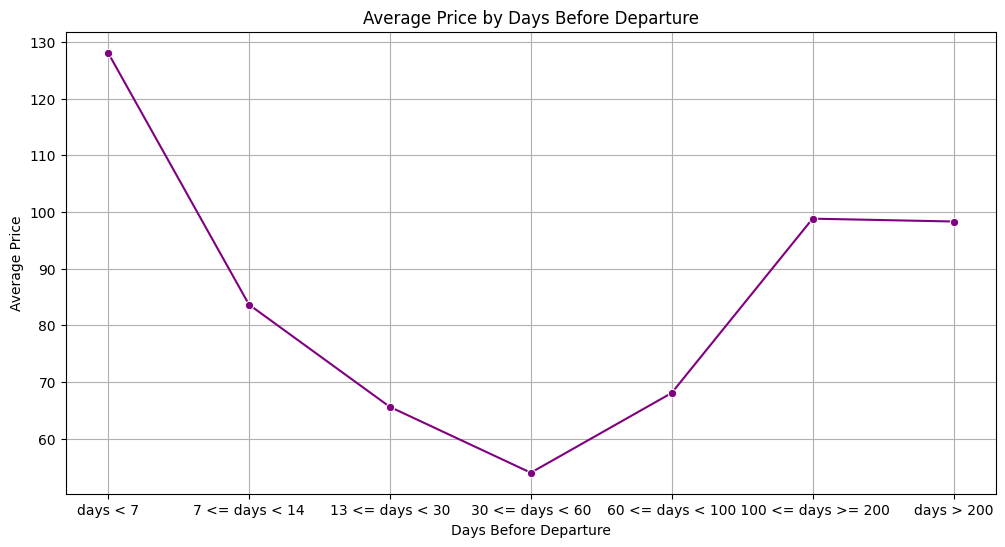

In [418]:
import seaborn as sns
import matplotlib.pyplot as plt

avg_price_by_range = iterations.zero.main_data.groupby('daysAgo_category')['price'].mean().reset_index()

# Sort the DataFrame by 'daysAgo_category' to ensure the plot uses the correct order
avg_price_by_range = avg_price_by_range.sort_values('daysAgo_category', ascending=True)

# Plotting average price by days range
plt.figure(figsize=(12,6))
sns.lineplot(x='daysAgo_category', y='price', data=avg_price_by_range, marker='o', color='purple')

# Adding labels and title
plt.title('Average Price by Days Before Departure')
plt.xlabel('Days Before Departure')
plt.ylabel('Average Price')

# Add grid to the plot
plt.grid(True)

# Show plot
plt.show()

The graph clearly shows that the **best time to buy** a ticket is **between 30 and 60 days before departure**, with prices peaking when tickets are booked much earlier or very close to the departure date.

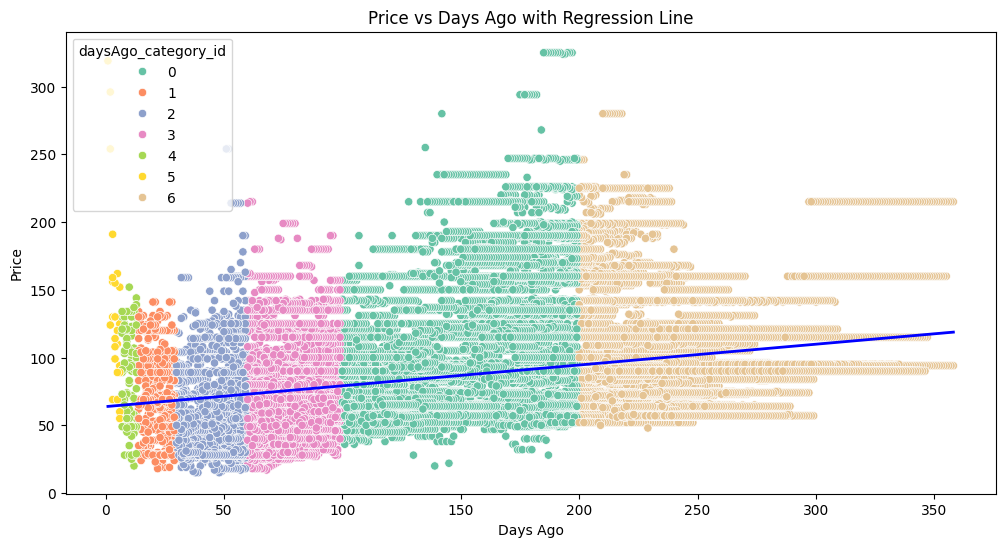

In [419]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='daysAgo', y='price', data=iterations.zero.main_data, hue='daysAgo_category_id', palette='Set2')
sns.regplot(x='daysAgo', y='price', data=iterations.zero.main_data, scatter=False, color='blue', line_kws={'linewidth': 2})
plt.title('Price vs Days Ago with Regression Line')
plt.xlabel('Days Ago')
plt.ylabel('Price')
plt.show()

This graph indicates that the number of days before departure (daysAgo) has a positive correlation with price, meaning that as flights are booked earlier, their prices tend to rise. This could be due to factors like demand for early bookings or promotions on last-minute deals. However, there is still a significant amount of variation in the price for each category, suggesting that other factors (like seasonality, holidays, etc.) could also be influencing ticket prices.

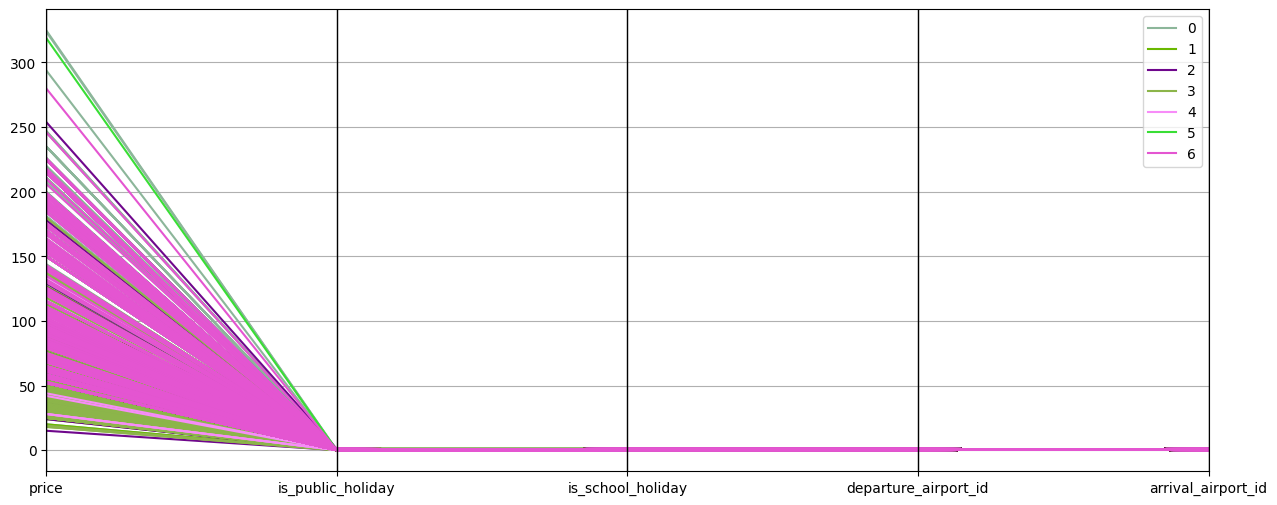

In [420]:
# Define numeric columns
numeric_candidates = ['price', 'is_public_holiday', 'is_school_holiday', 'departure_airport_id', 'arrival_airport_id', 'daysAgo_category_id']

# Plot the parallel coordinates with the encoded values
fig = plt.figure(figsize=[15,6])

ax = parallel_coordinates(iterations.zero.main_data[numeric_candidates].sample(5000).sort_values(by="daysAgo_category_id"), 
                          class_column='daysAgo_category_id')

plt.show()

From the parallel coordinates plot, here are the key observations we can conclude:
- Price variation is significant across the ``daysAgo_category_id`` categories, with some categories showing higher prices, especially as the number of days before departure increases.
- Features like *holidays* a d *airports*, and seem to have minimal effect on price in this case, and the main factor influencing price appears to be the number of days before departure (captured by ``daysAgo_category_id``).

### 💡 Feature Selection


To optimize our model, we must select only those features that best explain the variance in the target variable—the number of days before departure when the ticket is cheapest. Since flight prices fluctuate due to multiple factors, we will focus on features that exhibit distinguishable patterns across different days. Our dataset includes variables such as ``` departureDate, daysAgo, departure_airport, arrival_airport, and holiday indicators (is_public_holiday, is_school_holiday).```

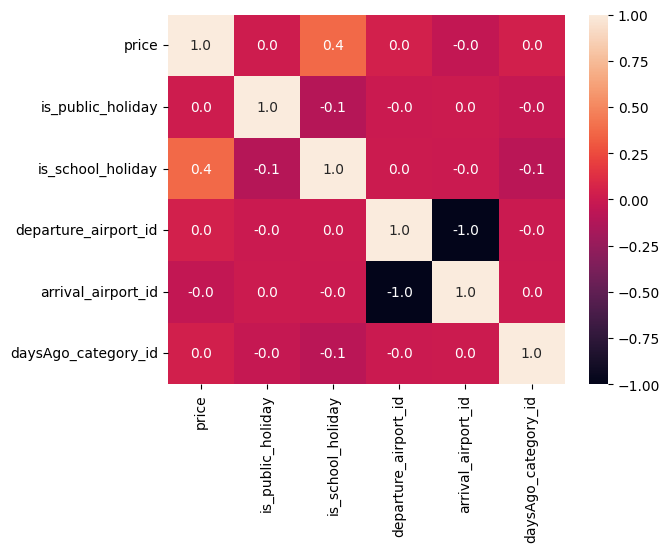

In [421]:
correlations = iterations.zero.main_data[numeric_candidates].corr()
plot = seaborn.heatmap(correlations, cbar=True, annot=True, fmt=".1f")

Conclusion:
- **Strong Factors**: ``is_school_holiday`` moderately influences price, while other features like `departure_airport_id` and `arrival_airport_id` seem to have little or no impact.
- **Weak/No Correlations**: Public holidays have *minimal impact* on ticket prices in this dataset, suggesting these features are *less important* for optimizing the model in terms of price prediction.

In [422]:
# Define the target and parameters
target = 'daysAgo_category_id'
params = ['price', 'is_public_holiday', 'is_school_holiday', 'departure_airport_id', 'arrival_airport_id', 'daysAgo']

X = iterations.zero.main_data[params]
y = iterations.zero.main_data[target]
# maybe try without public holidays

### 🪓 Splitting into train/test
80% of the data is used for training, and 20% for testing

In [423]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")
X_train

There are in total 33246 observations, of which 26596 are now in the train set, and 6650 in the test set.


,price,is_public_holiday,is_school_holiday,departure_airport_id,arrival_airport_id,daysAgo
4449,70,0,0,0,1,80
8127,94,0,1,1,0,190
7509,180,0,1,0,1,182
4384,42,0,0,1,0,89
44,99,0,1,0,1,17
...,...,...,...,...,...,...
12068,63,0,0,1,0,218
1358,94,0,0,1,0,75
1081,40,0,0,0,1,37
1101,26,0,0,1,0,82


# 🧬 Modelling

`k Nearest Neighbour` will be used at these first stages of the development

In [424]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the KNeighborsRegressor model
iterations.zero.knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model on the training data
iterations.zero.knn.fit(X_train, y_train)

# Predict the target values on the test set
pred = iterations.zero.knn.predict(X_test)

# 🔬 Evaluation
In order to shed some light on the results a classification report can be printed. This shows for every one of the classes how well the model performed.

In [425]:

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 0.02986466165413534
Root Mean Squared Error (RMSE): 0.2280878342884073
R² Score: 0.9926728936192618


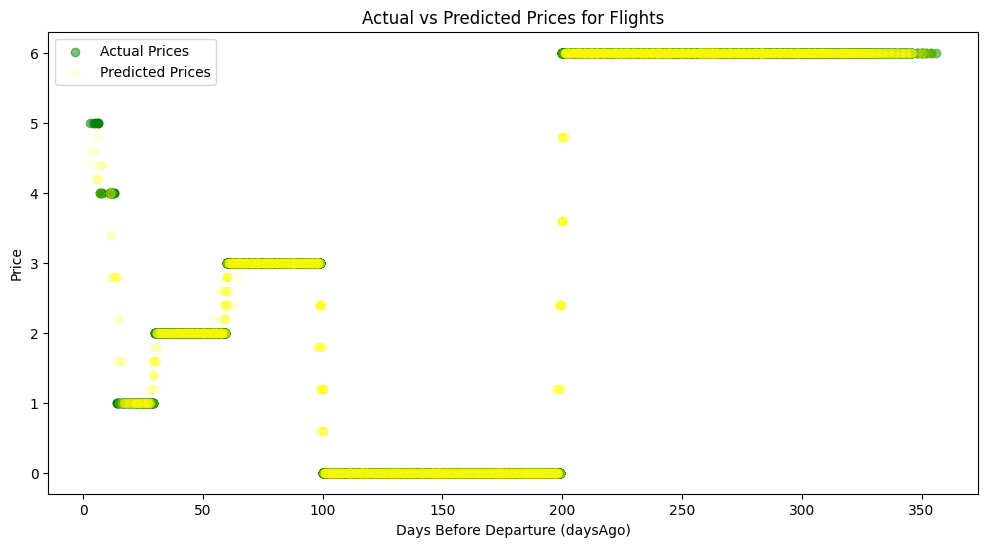

In [426]:
plt.figure(figsize=(12, 6))

# Scatter plot for actual prices
plt.scatter(X_test['daysAgo'], y_test, color='green', alpha=0.5, label='Actual Prices')

# Scatter plot for predicted prices
plt.scatter(X_test['daysAgo'], pred, color='yellow', alpha=0.1, label='Predicted Prices')

# Adding titles and labels
plt.title('Actual vs Predicted Prices for Flights')
plt.xlabel('Days Before Departure (daysAgo)')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()

Based on this chart, we can conclude that the model seems to correctly predict when the tickets will be the cheapest, but has difficulti when the actual value is close to the "edge" of the category and overlaps with another category.

---------------

# Cheapest day before a flight to buy tickets prediction - Iteration 1

In [427]:
import sklearn
import pandas as pd
import seaborn
import numpy as np

# 📦 Data provisioning
The flights is gathered from **google flights**, using a *webscraper*. It includes data from the routes **SOF-EIN** , **EIN-SOF** , **EIN-ATH** , **ISTANBUL-AMS** , **MUNICH - NEW YORK**. The dataset includes data from **03.2025 - 12.2025**

In [428]:
import glob

csv_files = glob.glob("./datasets/iteration1/*.csv")

iterations.one.original_main_data = pd.concat([pd.read_csv(file, parse_dates=["departureDate", "record_timestamp"], low_memory=False) for file in csv_files], ignore_index=True)

iterations.one.main_data = iterations.one.original_main_data.copy(deep=True)


# 📃 Sample the data


In [429]:
iterations.one.main_data.sample(10)

,daysAgo,departureDate,price,departure_airport,arrival_airport,is_public_holiday,is_school_holiday,airline,near_holiday,record_timestamp
28045,102,2025-05-28,77,İstanbul,Amsterdam,False,False,Turkish Airlines,1.0,2025-02-15
14503,82,2025-05-02,142,Sofia,Eindhoven,False,True,Ryanair,1.0,2025-02-09
10077,213,2025-09-07,104,Eindhoven,Athens,False,False,Aegean,1.0,2025-02-06
41780,118,2025-06-23,65,Eindhoven,Sofia,False,False,Wizzair,NaN,2025-02-25
13802,38,2025-04-19,95,Sofia,Eindhoven,True,False,Other,1.0,2025-03-12
30149,134,2025-07-01,80,İstanbul,Amsterdam,False,False,Turkish Airlines,-1.0,2025-02-17
10439,223,2025-09-13,107,Eindhoven,Athens,False,False,Transavia,1.0,2025-02-02
45469,211,2025-08-23,90,Eindhoven,Sofia,False,True,Wizzair,-1.0,2025-01-24
4121,98,2025-05-31,146,Eindhoven,Athens,False,False,Transavia,1.0,2025-02-22
10688,222,2025-09-17,94,Eindhoven,Athens,False,False,Transavia,-1.0,2025-02-07


In [430]:
group_info = iterations.one.main_data.groupby(["departure_airport"])["departure_airport"].count()
group_info

departure_airport
Eindhoven    23845
New York     11848
Sofia        11987
İstanbul     12316
Name: departure_airport, dtype: int64

# 🛠️ Preprocessing 

The step of preprocessing contains several activities to consider before we can start training the algorithm and produce a model that can predict our target variable, in this case the days before a flight, containing the cheapest tickets. 

## 🎯 Target Variable


First, as the algorhitm is categorical, we need to convert the target variable into a category.

In [431]:
import pandas as pd
import numpy as np
import math

# Define bin edges and corresponding category labels
bins = [7, 14, 30, 60, 100, 200]  # Upper limits for each category
category_order = [
    'days < 7', '7 <= days < 14', '14 <= days < 30',
    '30 <= days < 60', '60 <= days < 100', '100 <= days < 200', 'days > 200'
]

# Assign categories based on bin indices
indices = np.digitize(iterations.one.main_data["daysAgo"], bins, right=False)
iterations.one.main_data["daysAgo_category"] = np.array(category_order)[indices]

# Convert to categorical with the specified order
iterations.one.main_data['daysAgo_category'] = pd.Categorical(iterations.one.main_data['daysAgo_category'], categories=category_order, ordered=True)

## Addming new feature - distance between departure and arrival airports

In [432]:
airport_coords = {
    'New York': (40.7128, -74.0060),
    'Amsterdam': (52.3676, 4.9041),
    'Athens': (37.9838, 23.7275),
    'Eindhoven': (51.4416, 5.4697),
    'Sofia': (42.6975, 23.3242),
    'Washington, D.C.': (38.8951, -77.0364),
    'İstanbul': (41.0082, 28.9784)
}

# Function to calculate Haversine distance
# Source: https://stackoverflow.com/questions/25711895/the-result-by-haversine-formula-is-meter-o-kmeter
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c  # Distance in km

# Function to calculate distance for each row in DataFrame
def calculate_distance(row):
    dep = row['departure_airport']
    arr = row['arrival_airport']
    if dep in airport_coords and arr in airport_coords:
        lat1, lon1 = airport_coords[dep]
        lat2, lon2 = airport_coords[arr]
        return haversine_distance(lat1, lon1, lat2, lon2)
    else:
        return None  # Handle missing airport coordinates

# Apply the function to compute distances in your existing dataset
iterations.one.main_data['airport_distance_km'] = iterations.one.main_data.apply(calculate_distance, axis=1)
iterations.one.main_data.sample(10)

,daysAgo,departureDate,price,departure_airport,arrival_airport,is_public_holiday,is_school_holiday,airline,near_holiday,record_timestamp,daysAgo_category,airport_distance_km
13935,91,2025-04-22,110,Sofia,Eindhoven,False,False,Ryanair,1.0,2025-01-21,60 <= days < 100,1658.335311
22116,219,2025-09-04,141,Sofia,Eindhoven,False,False,Ryanair,1.0,2025-01-28,days > 200,1658.335311
29241,100,2025-06-16,93,İstanbul,Amsterdam,False,False,Pegasus,NaN,2025-03-08,100 <= days < 200,2211.947562
32036,133,2025-07-31,133,İstanbul,Amsterdam,False,True,Turkish Airlines,-1.0,2025-03-20,100 <= days < 200,2211.947562
49806,89,2025-04-23,57,New York,"Washington, D.C.",False,False,Delta,1.0,2025-01-24,60 <= days < 100,328.393017
18144,161,2025-07-01,52,Sofia,Eindhoven,False,False,Ryanair,-1.0,2025-01-21,100 <= days < 200,1658.335311
812,59,2025-04-07,136,Eindhoven,Athens,False,False,Transavia,NaN,2025-02-07,30 <= days < 60,2067.423123
50483,95,2025-05-05,91,New York,"Washington, D.C.",False,False,Delta,1.0,2025-01-30,60 <= days < 100,328.393017
20311,164,2025-08-05,110,Sofia,Eindhoven,False,True,Other,0.0,2025-02-22,100 <= days < 200,1658.335311
27152,115,2025-05-14,88,İstanbul,Amsterdam,False,False,Turkish Airlines,NaN,2025-01-19,100 <= days < 200,2211.947562


Then, we need to convert the respectable non numerical values (airports and holidays) into numberical values

Why One-Hot Encoding the Airline Might Be Better:
1.	Lower Correlation with Other Features – The airline feature does not show strong linear correlations with other features, which suggests that it might not introduce significant redundancy when one-hot encoded.
2.	Categorical Nature of Airlines – Airlines are naturally categorical and one-hot encoding could help preserve distinct airline identities without introducing ordinal relationships that don’t exist.
3.	Potential Interactions – Different airlines may have distinct pricing strategies that one-hot encoding can help capture.

Why Keeping Departure/Arrival Airports as Label Encoded Might Be Better:
1.	Strong Correlation Between Airports – Departure and arrival airports show higher correlations among themselves. This might indicate that the distance between airports (which you could introduce as a feature) could be a more meaningful numerical representation.
2.	High-Dimensionality Risk – One-hot encoding airports can significantly increase the number of features, especially if there are many unique airports. This could make training less efficient and introduce sparsity issues

In [433]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
iterations.one.main_data["daysAgo_category_id"] = encoder.fit_transform(iterations.one.main_data["daysAgo_category"])
iterations.one.main_data.drop(columns=['daysAgo_category'], inplace=True)

# Perform one-hot encoding on 'airline' and label encoding on airports
iterations.one.main_data = pd.get_dummies(iterations.one.main_data, columns=['airline'])

cols_to_convert = iterations.one.main_data.columns[-9:]  # Select the last 9 columns, which are one-hot encoded
iterations.one.main_data[cols_to_convert] = iterations.one.main_data[cols_to_convert].astype(int)  # Convert True/False to 0/1

iterations.one.main_data['departure_date_unix'] = iterations.one.main_data['departureDate'].astype('int64') // 10**9
iterations.one.main_data['record_timestamp_unix'] = iterations.one.main_data['record_timestamp'].astype('int64') // 10**9
iterations.one.main_data = pd.get_dummies(iterations.one.main_data, columns=['near_holiday']) # as the columns is -1, 0, 1 which messes with the algorithm

iterations.one.main_data["departure_airport"] = encoder.fit_transform(iterations.one.main_data["departure_airport"])
iterations.one.main_data["arrival_airport"] = encoder.fit_transform(iterations.one.main_data["arrival_airport"])

#removing these columns as the  "near_holiday" has the same purpose

iterations.one.main_data.drop(columns=['is_public_holiday'], inplace=True)
iterations.one.main_data.drop(columns=['is_school_holiday'], inplace=True)

#removing these colums as they are converted to unix
iterations.one.main_data.drop(columns=['departureDate'], inplace=True)
iterations.one.main_data.drop(columns=['record_timestamp'], inplace=True)


col = iterations.one.main_data.pop("daysAgo_category_id")  # Remove the column

iterations.one.main_data_prepared = iterations.one.main_data.copy(deep=True)

iterations.one.main_data.insert(0, "daysAgo_category_id", col)  # Insert it at 0

#Removing the column daysAgo as this attempt will be categorical
iterations.one.main_data.drop(columns=['daysAgo'], inplace=True)

iterations.one.main_data.sample(10)

,daysAgo_category_id,price,departure_airport,arrival_airport,airport_distance_km,airline_Aegean,airline_Delta,airline_Other,airline_Pegasus,airline_Republic American,airline_Ryanair,airline_Transavia,airline_Turkish Airlines,airline_Wizzair,departure_date_unix,record_timestamp_unix,near_holiday_-1.0,near_holiday_0.0,near_holiday_1.0
36969,2,89,0,3,1658.335311,0,0,0,0,0,0,0,0,1,1743724800,1741132800,False,False,False
35211,6,84,3,0,2211.947562,0,0,0,0,0,0,0,1,0,1758412800,1738368000,True,False,False
36837,2,30,0,3,1658.335311,0,0,0,0,0,0,0,0,1,1743552000,1740268800,False,False,False
53329,0,51,1,4,328.393017,0,0,0,0,1,0,0,0,0,1750377600,1741651200,False,False,False
47054,6,150,0,3,1658.335311,0,0,0,0,0,0,0,0,1,1758153600,1737590400,True,False,False
2688,0,129,0,1,2067.423123,0,0,0,0,0,0,1,0,0,1746662400,1737590400,False,False,True
41880,0,64,0,3,1658.335311,0,0,0,0,0,1,0,0,0,1750809600,1738540800,False,False,False
9332,6,64,0,1,2067.423123,0,0,0,0,0,0,1,0,0,1756166400,1737676800,False,False,True
18249,0,46,2,2,1658.335311,0,0,0,0,0,0,0,0,1,1751414400,1741219200,True,False,False
1611,3,184,0,1,2067.423123,0,0,0,0,0,0,1,0,0,1745107200,1739404800,True,False,False


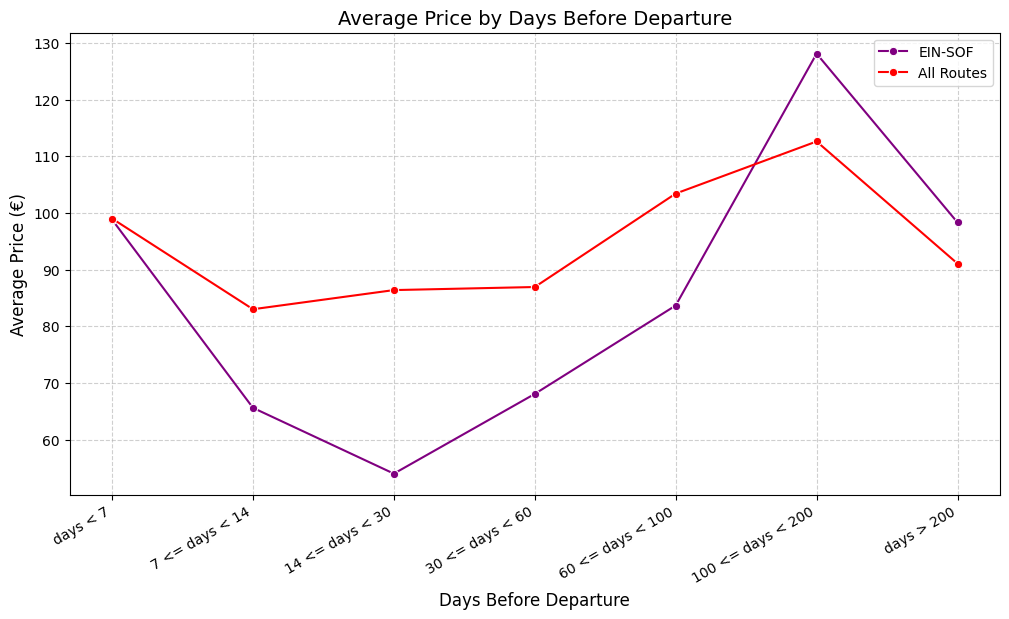

In [434]:
# Create a mapping from category_id to category name
category_mapping = {i: category_order[i] for i in range(len(category_order))}

# Function to process the data
def process_avg_price_by_category(df, category_id_column):
    # Group by 'daysAgo_category_id' and calculate mean price
    avg_price_by_range = df.groupby(category_id_column)['price'].mean().reset_index()

    # Map category ID to category name
    avg_price_by_range['daysAgo_category'] = avg_price_by_range[category_id_column].map(category_mapping)

    # Convert to categorical type with correct ordering
    avg_price_by_range['daysAgo_category'] = pd.Categorical(
        avg_price_by_range['daysAgo_category'], categories=category_order, ordered=True
    )

    # Sort data based on category order
    avg_price_by_range = avg_price_by_range.sort_values('daysAgo_category')

    return avg_price_by_range

# Process data for both datasets
avg_price_by_range_0 = process_avg_price_by_category(iterations.zero.main_data, 'daysAgo_category_id')
avg_price_by_range_1 = process_avg_price_by_category(iterations.one.main_data, 'daysAgo_category_id')

# Plotting
plt.figure(figsize=(12,6))
sns.lineplot(x='daysAgo_category', y='price', data=avg_price_by_range_0, marker='o', color='purple', label='EIN-SOF')
sns.lineplot(x='daysAgo_category', y='price', data=avg_price_by_range_1, marker='o', color='red', label='All Routes')

# Labels and title
plt.title('Average Price by Days Before Departure', fontsize=14)
plt.xlabel('Days Before Departure', fontsize=12)
plt.ylabel('Average Price (€)', fontsize=12)

# Rotate x-axis labels properly
plt.xticks(rotation=30, ha='right')

# Add legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()

Conclusion:
- EIN-SOF has more extreme price fluctuations
	- The EIN-SOF route shows sharper drops and peaks compared to the overall trend.
	- Prices drop significantly for this route between 7-30 days before departure, reaching a much lower minimum than the general trend.
	- It also experiences a more dramatic peak beyond 100 days before departure, suggesting a stronger price hike compared to other routes.
- Overall trend (red line) is more stable
	-	The general trend for all routes follows a similar pattern but is smoother, without extreme dips or spikes.
	-	It suggests a more predictable pricing structure across multiple routes, whereas EIN-SOF might be influenced by specific demand fluctuations.

Now we will create several graphs to visualize relationships between the features of the dataset

### 💡 Feature Selection


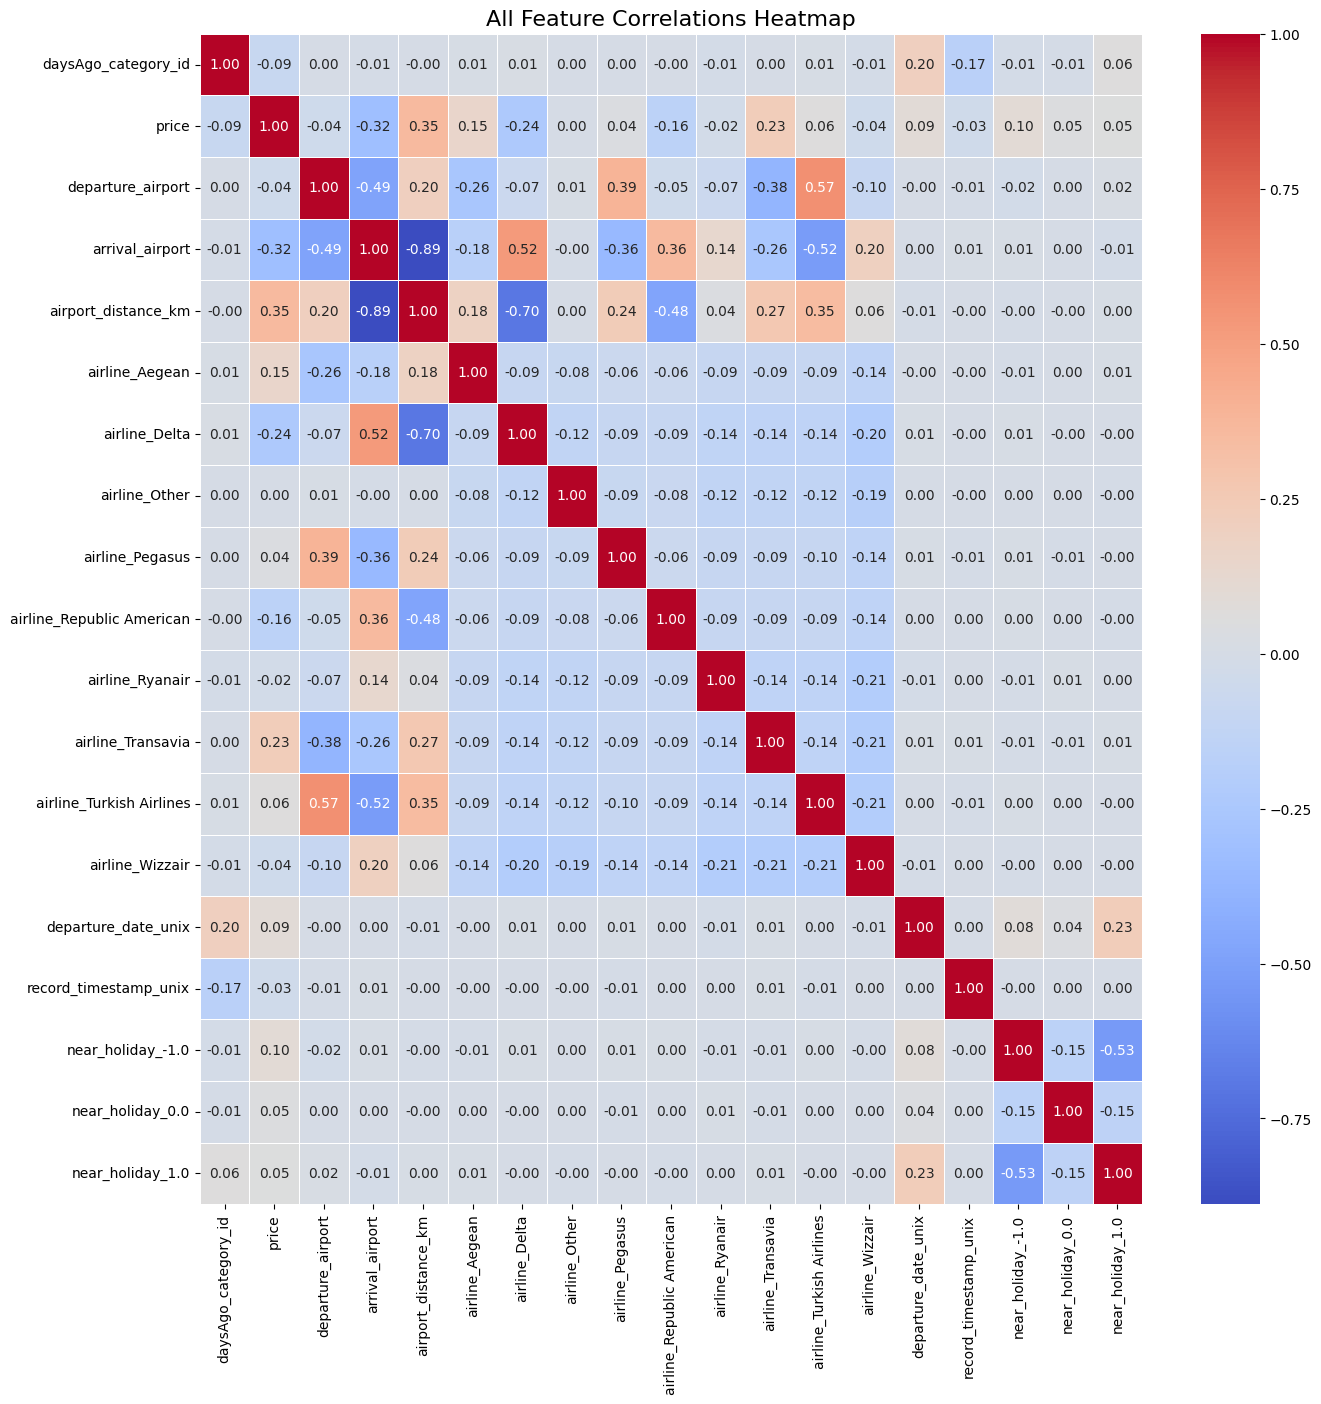

In [435]:
import seaborn as sns
import matplotlib.pyplot as plt

correlations = iterations.one.main_data.corr()

plt.figure(figsize=(min(20, 0.8 * len(correlations)), min(20, 0.8 * len(correlations))))  

sns.heatmap(
    correlations, 
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cmap="coolwarm",
)

plt.title("All Feature Correlations Heatmap", fontsize=16)
plt.show()

In [436]:
correlation_target = iterations.one.main_data.corr()['daysAgo_category_id'].sort_values(ascending=False)
print(correlation_target)

daysAgo_category_id          1.000000
departure_date_unix          0.203784
near_holiday_1.0             0.057089
airline_Delta                0.011721
airline_Turkish Airlines     0.007222
airline_Aegean               0.005125
airline_Transavia            0.003665
airline_Pegasus              0.003416
departure_airport            0.003347
airline_Other                0.002389
airline_Republic American   -0.001264
airport_distance_km         -0.001932
arrival_airport             -0.006253
near_holiday_0.0            -0.006745
near_holiday_-1.0           -0.010950
airline_Ryanair             -0.011575
airline_Wizzair             -0.014237
price                       -0.087728
record_timestamp_unix       -0.167054
Name: daysAgo_category_id, dtype: float64


We can see that generally the correlations are low, but lets select the ones with highest absolute value

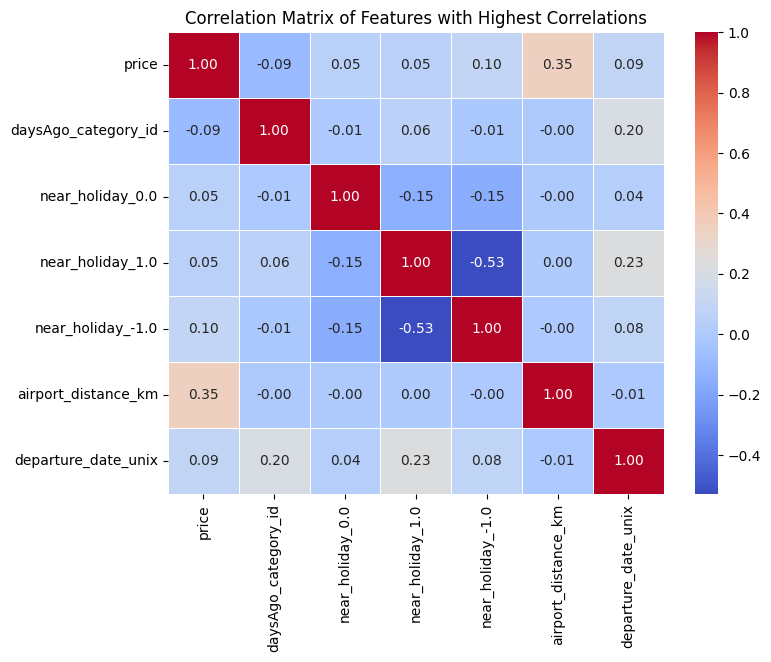

In [437]:
most_important_columns = ['price', 'daysAgo_category_id', 'near_holiday_0.0','near_holiday_1.0','near_holiday_-1.0', 'airport_distance_km', 'departure_date_unix']
correlation_matrix = iterations.one.main_data[most_important_columns].corr()

# Plot heatmap to visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features with Highest Correlations")
plt.show()

In [438]:
correlation_target = correlation_matrix['daysAgo_category_id'].sort_values(ascending=False)
print(correlation_target)

daysAgo_category_id    1.000000
departure_date_unix    0.203784
near_holiday_1.0       0.057089
airport_distance_km   -0.001932
near_holiday_0.0      -0.006745
near_holiday_-1.0     -0.010950
price                 -0.087728
Name: daysAgo_category_id, dtype: float64


We can conclude:
- Price vs. Airport Distance
    - The highest positive correlation is between price and airport_distance_km. This suggests that flights covering longer distances tend to have higher prices, which aligns with common expectations.
- 	Holidays are not a key factor: Despite common beliefs, near_holiday does not have a high correlation with price.

In [439]:
# Define the target and parameters
target = 'daysAgo_category_id'

X = iterations.one.main_data[most_important_columns]
y = iterations.one.main_data[target]

### 🪓 Splitting into train/test
80% of the data is used for training, and 20% for testing

In [440]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

X_train

There are in total 59996 observations, of which 47996 are now in the train set, and 12000 in the test set.


,price,daysAgo_category_id,near_holiday_0.0,near_holiday_1.0,near_holiday_-1.0,airport_distance_km,departure_date_unix
33499,177,0,False,True,False,2211.947562,1755993600
50813,44,3,False,True,False,328.393017,1746835200
11167,116,6,False,True,False,2067.423123,1758758400
8978,64,0,False,False,True,2067.423123,1755648000
35578,72,6,False,True,False,2211.947562,1758931200
...,...,...,...,...,...,...,...
48152,91,3,False,False,False,328.393017,1742774400
30864,68,0,False,True,False,2211.947562,1752364800
6193,146,0,False,False,True,2067.423123,1751587200
48042,115,6,False,False,True,1658.335311,1759536000


# 🧬 Modelling

`k Nearest Neighbour` will be used at these first stages of the development

In [441]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the KNeighborsRegressor model
iterations.one.knn = KNeighborsClassifier()

# Fit the model on the training data
iterations.one.knn.fit(X_train, y_train)

# Predict the target values on the test set
pred = iterations.one.knn.predict(X_test)

# 🔬 Evaluation
In order to shed some light on the results a classification report can be printed. 

In [442]:

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 0.11608333333333333
Root Mean Squared Error (RMSE): 0.5833095233235953
R² Score: 0.9298642178500762


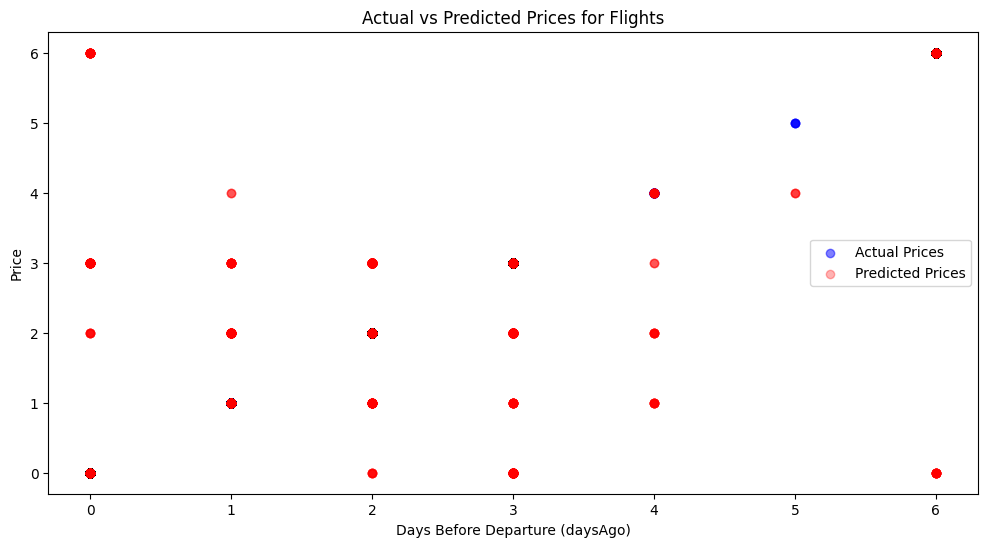

In [443]:
plt.figure(figsize=(12, 6))

# Scatter plot for actual prices
plt.scatter(X_test['daysAgo_category_id'], y_test, color='blue', alpha=0.5, label='Actual Prices')

# Scatter plot for predicted prices
plt.scatter(X_test['daysAgo_category_id'], pred, color='red', alpha=0.3, label='Predicted Prices')

# Adding titles and labels
plt.title('Actual vs Predicted Prices for Flights')
plt.xlabel('Days Before Departure (daysAgo)')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()

Despite the high accuracy and R2, we can see that model does not actually provide correct predictions. Lets change to Linear Regression and see if we can make the model smarter :)

## Model change -> Linear Regression

Going back to othe original dataset before categorising the target variable

In [460]:
iterations.one.main_data_prepared.sample(10)

iterations.one.main_data = iterations.one.main_data_prepared.copy(deep=True)


## 🎯 Target Variable


Now I will try with the actual and most accurate target variable - daysAgo for a flight

### 💡 Feature Selection


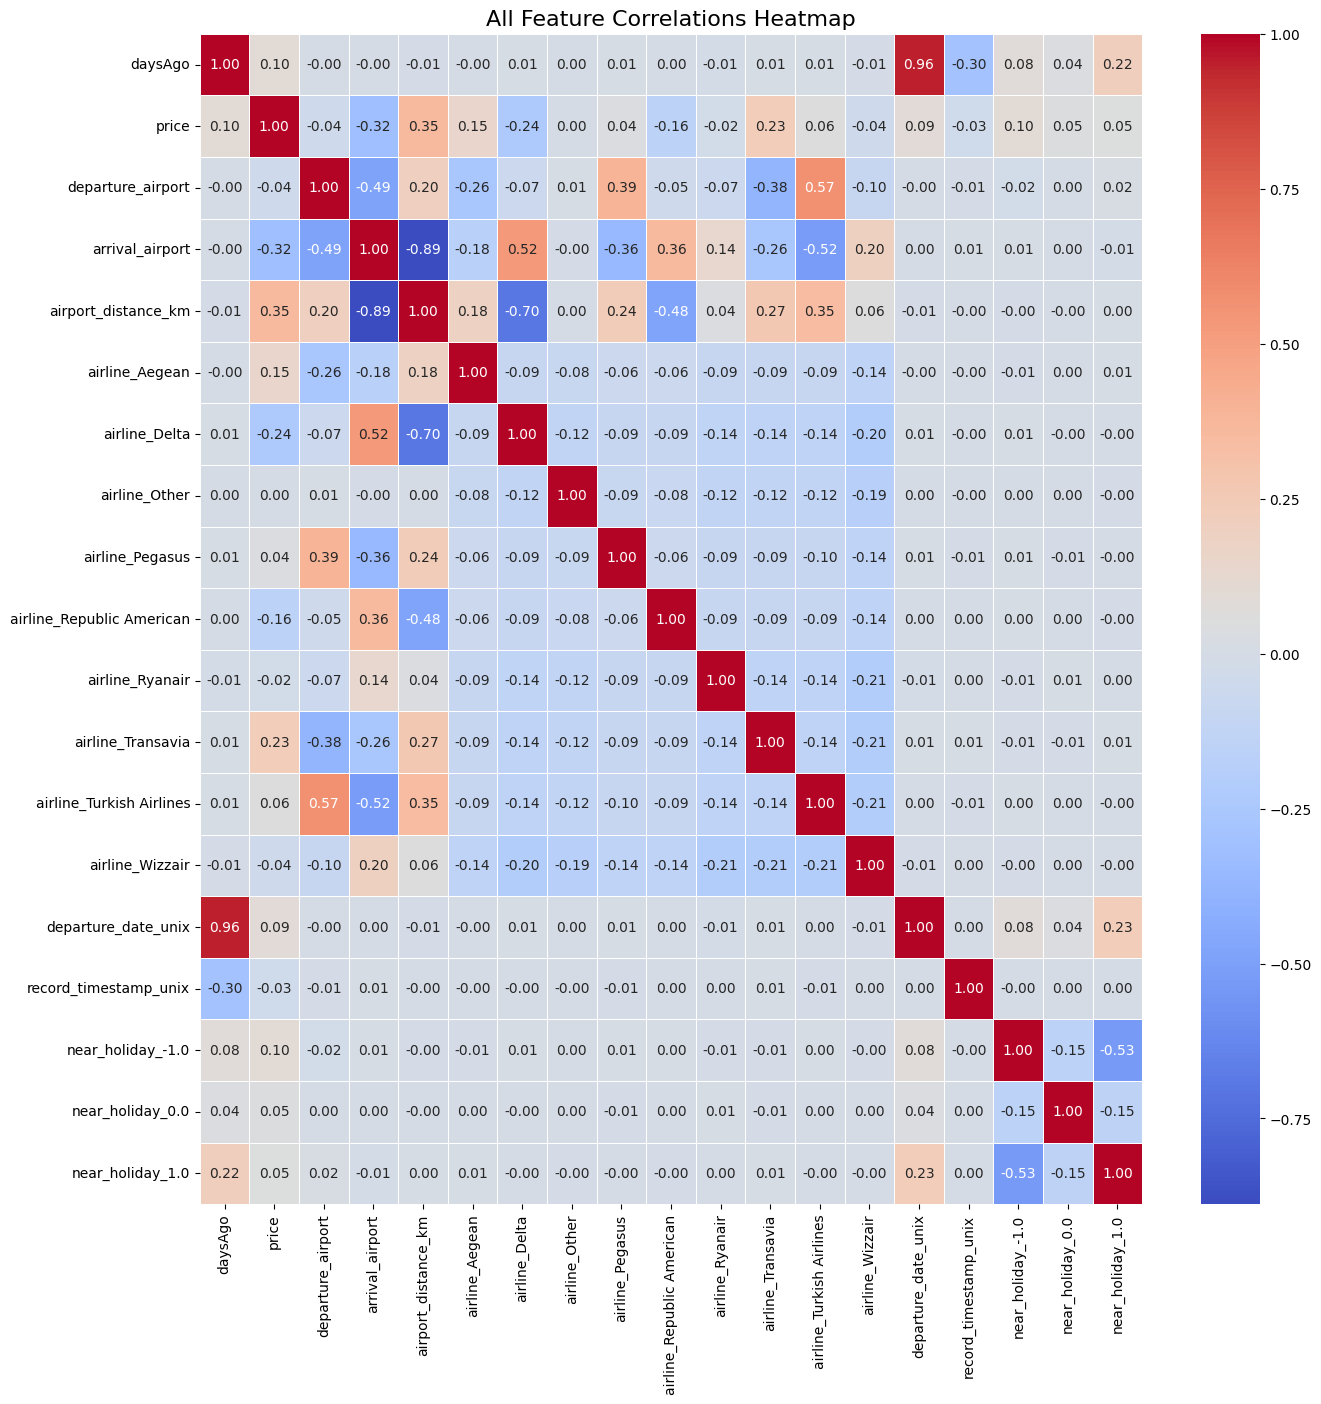

In [445]:
import seaborn as sns
import matplotlib.pyplot as plt

correlations = iterations.one.main_data.corr()

plt.figure(figsize=(min(20, 0.8 * len(correlations)), min(20, 0.8 * len(correlations))))  

sns.heatmap(
    correlations, 
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cmap="coolwarm",
)

plt.title("All Feature Correlations Heatmap", fontsize=16)
plt.show()

In [446]:
correlation_target = iterations.one.main_data.corr()['daysAgo']
correlation_target_sorted = correlation_target.reindex(correlation_target.abs().sort_values(ascending=False).index)
print(correlation_target_sorted)

daysAgo                      1.000000
departure_date_unix          0.955349
record_timestamp_unix       -0.295416
near_holiday_1.0             0.215874
price                        0.095231
near_holiday_-1.0            0.078429
near_holiday_0.0             0.035218
airline_Ryanair             -0.013991
airline_Delta                0.010156
airline_Wizzair             -0.009907
airline_Pegasus              0.007640
airline_Transavia            0.005539
airport_distance_km         -0.005304
airline_Turkish Airlines     0.005045
airline_Aegean              -0.002649
airline_Republic American    0.001608
airline_Other                0.001443
arrival_airport             -0.001054
departure_airport           -0.000245
Name: daysAgo, dtype: float64


Now we have greater correlelation between the target and other features,compared to the categorical target variable

Correlation of most important features, where the correlations is above 0.07

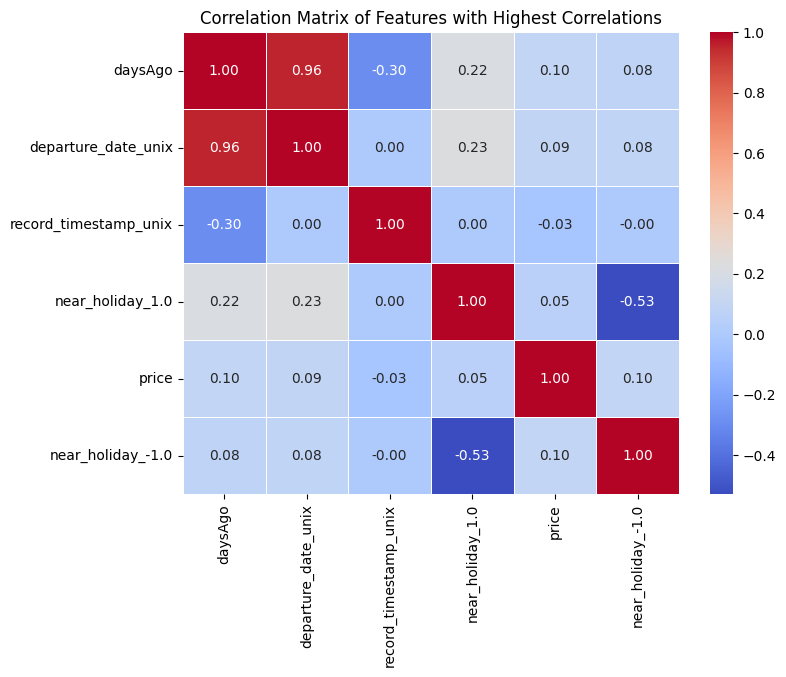

In [447]:
most_important_columns = ['daysAgo', 'departure_date_unix', 'record_timestamp_unix','near_holiday_1.0','price', 'near_holiday_-1.0']
correlation_matrix = iterations.one.main_data[most_important_columns].corr()

# Plot heatmap to visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features with Highest Correlations")
plt.show()

In [448]:
# Define the target and parameters
target = 'daysAgo'
params = ['departure_date_unix', 'record_timestamp_unix','near_holiday_1.0','price', 'near_holiday_-1.0']
X = iterations.one.main_data[most_important_columns]
y = iterations.one.main_data[target]

### 🪓 Splitting into train/test
80% of the data is used for training, and 20% for testing

In [449]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

X_train

There are in total 59996 observations, of which 47996 are now in the train set, and 12000 in the test set.


,daysAgo,departure_date_unix,record_timestamp_unix,near_holiday_1.0,price,near_holiday_-1.0
33441,175,1755907200,1740787200,True,207,False
59441,199,1759190400,1741996800,False,42,False
48750,57,1743638400,1738713600,False,91,False
32606,193,1754784000,1738108800,True,145,False
18802,123,1752192000,1741564800,True,53,False
...,...,...,...,...,...,...
19330,153,1752969600,1739750400,False,63,True
53268,100,1750291200,1741651200,False,51,False
44427,199,1754438400,1737244800,False,79,True
26002,70,1745539200,1739491200,True,109,False


# 🧬 Modelling

`Linear Regression` will be tried for the iteration 1 attempt

In [450]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the Linear Regression model
iterations.one.lr = LinearRegression()

# Fit the model on the training data
iterations.one.lr.fit(X_train, y_train)

# Predict the target values on the test set
pred = iterations.one.lr.predict(X_test)

# 🔬 Evaluation
In order to shed some light on the results a classification report can be printed. 

In [451]:

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 2.550981056022768e-12
Root Mean Squared Error (RMSE): 3.1243092886687085e-12
R² Score: 1.0


Wow! The R2 Score is 1. The model seems to be very good, however that does not always that the predictions will be correct. Lets test it out

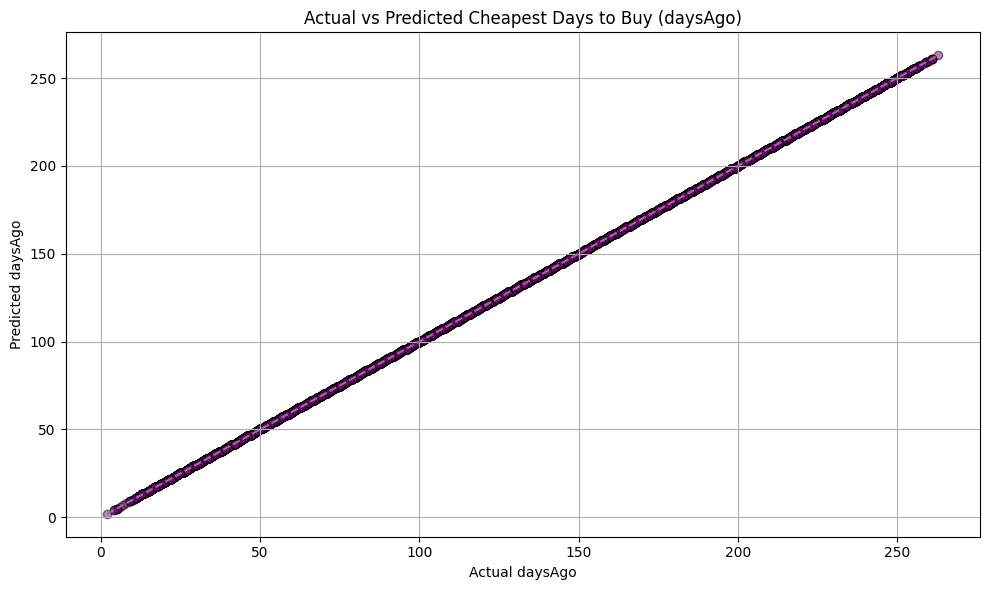

In [452]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Scatter plot: Actual vs Predicted
plt.scatter(y_test, pred, alpha=0.5, color='purple', edgecolors='k')

# Add a reference line (perfect predictions)
min_val = min(min(y_test), min(pred))
max_val = max(max(y_test), max(pred))
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--')

plt.xlabel('Actual daysAgo')
plt.ylabel('Predicted daysAgo')
plt.title('Actual vs Predicted Cheapest Days to Buy (daysAgo)')
plt.grid(True)
plt.tight_layout()
plt.show()

The scatter plot of Actual vs Predicted looks excellent — the points fall almost perfectly on the red dashed line (which represents perfect predictions). This suggests that my model is doing an outstanding job. However, it shouldn't be a straight line, lets keep on testing to see where the problem is.

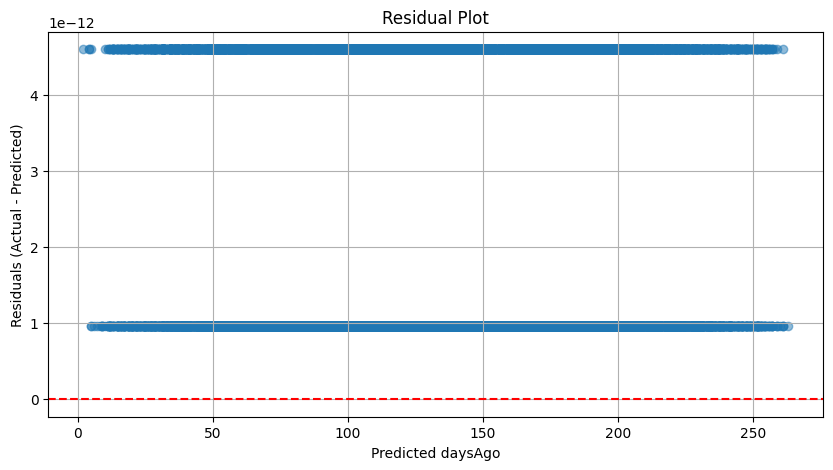

In [454]:
residuals = y_test - pred

plt.figure(figsize=(10, 5))
plt.scatter(pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted daysAgo')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

The residuals plot shows:
- The residuals are extremely close to zero, with almost no visible spread.
- The y-axis scale is tiny (1e-12), meaning the differences between actual and predicted values are near zero — essentially machine precision.
- This implies the model is predicting the target perfectly (or nearly perfectly).

However, I still believe that there is a problem somewhere

In [463]:
import pandas as pd

comparison = pd.DataFrame({
    'Actual': y_test[:20],
    'Predicted': y_pred[:20],
    'Residual': y_test[:20] - y_pred[:20]
})
print(comparison)

       Actual  Predicted  Residual
9083      215        202        13
58849     233        136        97
58188     212        202        10
57782     184        202       -18
36243     208        136        72
24009     248        202        46
52831     103         72        31
50394      59        202      -143
18110     133        136        -3
2219       78        136       -58
35708     239        136       103
55573     152         70        82
24884      57        202      -145
56834     202        136        66
44927     195        136        59
58146     192         70       122
49011      77        136       -59
45217     153        202       -49
12471      67        202      -135
2710       83        136       -53


Despite what the residual plot suggested earlier, the model is **definitely** not accurate. It’s:
-	Leading to massive errors in predictions
-	Giving an illusion of precision due to floating-point weirdness (which is why you saw residuals like 1e-12 — likely from identical predictions where actuals happened to match)